## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (15%)
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7465000152587891
epoch 2: valid acc = 0.7990000247955322
epoch 3: valid acc = 0.8180000185966492
epoch 4: valid acc = 0.8385000228881836
epoch 5: valid acc = 0.8410000205039978
epoch 6: valid acc = 0.8500000238418579
epoch 7: valid acc = 0.8615000247955322
epoch 8: valid acc = 0.8700000047683716
epoch 9: valid acc = 0.8709999918937683
epoch 10: valid acc = 0.8744999766349792
epoch 11: valid acc = 0.8755000233650208
epoch 12: valid acc = 0.8769999742507935
epoch 13: valid acc = 0.8784999847412109
epoch 14: valid acc = 0.8799999952316284
epoch 15: valid acc = 0.8809999823570251
test acc = 0.857200026512146


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your 4-layer MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

In [ ]:
# Create you MLP using TensorFlow functions.

In [4]:
## Four-layer net in tensorflow (eager execution mode)
hidden_dim1 = 256
hidden_dim2 = 128
hidden_dim3 = 64
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(0.01*np.random.rand(X_train.shape[1], hidden_dim1).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim1,)).astype('float32'))
        self.W2 = tf.Variable(0.01*np.random.rand(hidden_dim1, hidden_dim2).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim2,)).astype('float32'))
        self.W3 = tf.Variable(0.01*np.random.rand(hidden_dim2, hidden_dim3).astype('float32'))
        self.b3 = tf.Variable(np.zeros((hidden_dim3,)).astype('float32'))
        self.W4 = tf.Variable(0.01*np.random.rand(hidden_dim3, 20).astype('float32'))
        self.b4 = tf.Variable(np.zeros((20,)).astype('float32'))
        
    def call(self, inputs):
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        h3 = tf.nn.relu(tf.matmul(h2, self.W3) + self.b3)
        out = tf.matmul(h3, self.W4) + self.b4
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2) + tf.nn.l2_loss(model.W3) + tf.nn.l2_loss(model.W4)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss
# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2, model.W3, model.b3, model.W4, model.b4])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 100
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2, 
                                              model.W3, model.b3, model.W4, model.b4]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.1784999966621399
epoch 2: valid acc = 0.18199999630451202
epoch 3: valid acc = 0.18250000476837158
epoch 4: valid acc = 0.18449999392032623
epoch 5: valid acc = 0.18400000035762787
epoch 6: valid acc = 0.18400000035762787
epoch 7: valid acc = 0.18449999392032623
epoch 8: valid acc = 0.18299999833106995
epoch 9: valid acc = 0.18199999630451202
epoch 10: valid acc = 0.18250000476837158
epoch 11: valid acc = 0.18199999630451202
epoch 12: valid acc = 0.18150000274181366
epoch 13: valid acc = 0.18199999630451202
epoch 14: valid acc = 0.18299999833106995
epoch 15: valid acc = 0.1835000067949295
epoch 16: valid acc = 0.18250000476837158
epoch 17: valid acc = 0.18199999630451202
epoch 18: valid acc = 0.18400000035762787
epoch 19: valid acc = 0.18549999594688416
epoch 20: valid acc = 0.18799999356269836
epoch 21: valid acc = 0.1914999932050705
epoch 22: valid acc = 0.19949999451637268
epoch 23: valid acc = 0.20350000262260437
epoch 24: valid acc = 0.21150000393390656
epoc

### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [6]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(784,)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(50, activation='softmax')
])
# END of your code
#############################################################



#############################################################
# TODO: compile the model, set optimizer and loss
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=1e-4), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
model.summary()
# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset
model.fit(
    X_train, y_train,
    epochs=15, verbose=2,
    validation_data=(X_val, y_val)
)

# END of your code
#############################################################

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                15050     
Total params: 340,850
Trainable params: 340,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1813/1813 - 3s - loss: 3.8673 - accuracy: 0.0779 - val_loss: 3.8551 - val_accuracy: 0.0900
Epoch 2/15
1813/1813 - 3s - loss: 3.8426 - accuracy: 0.1026 - val_loss: 3.8454 - val_accuracy: 0.0990
Epoch 3/15
1813/1813 - 3s - loss: 3.8180 -

## Part 2: t-SNE (5%)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [7]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [8]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [9]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=25.0)
print("it takes {} seconds".format(time.time()-tic))

2.884413474476356
The 100 th loop cost: 11.721131939147025, computation time: 2.303664207458496
The 200 th loop cost: 0.5430185366937715, computation time: 4.517664432525635
The 300 th loop cost: 0.505938087057304, computation time: 6.687664985656738
The 400 th loop cost: 0.4995598575788116, computation time: 8.902668237686157
The 500 th loop cost: 0.49813202934279427, computation time: 11.044665813446045
The 600 th loop cost: 0.4976039962552066, computation time: 13.197667360305786
The 700 th loop cost: 0.49736072845981477, computation time: 15.340665578842163
The 800 th loop cost: 0.4972350526612644, computation time: 17.44769549369812
The 900 th loop cost: 0.49713653952356895, computation time: 19.59466791152954
The 1000 th loop cost: 0.49709530834318355, computation time: 21.754666328430176
it takes 22.80430293083191 seconds


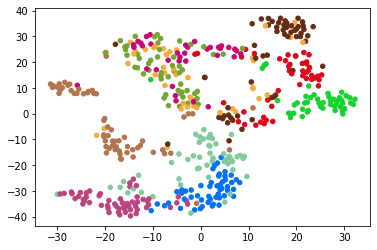

In [10]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [11]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose, momentum=0.001)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.819, new learning rate = 0.00095
epoch 2: valid acc = 0.8495, new learning rate = 0.0009025
epoch 3: valid acc = 0.864, new learning rate = 0.000857375
epoch 4: valid acc = 0.86, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.869, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.875, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.876, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.872, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.873, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.883, new learning rate = 0.0005987369392383785
test acc: 0.8661


0.8661

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [12]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then   #
# apply softmax to obtain output of the MLP model.                          #
#############################################################################
from utils.classifiers.softmax import softmax
input_x = model.layers[0].feedforward(X)
input_x = model.layers[1].feedforward(input_x)
out = softmax(input_x)
Y = tsne(out, low_dim=2, perplexity=25.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.0986677692466115
The 100 th loop cost: 8.663698331059738, computation time: 2.0879697799682617
The 200 th loop cost: 0.21215639996083702, computation time: 4.318970203399658
The 300 th loop cost: 0.1717607882969614, computation time: 6.4459710121154785
The 400 th loop cost: 0.1598997763748237, computation time: 8.525970220565796
The 500 th loop cost: 0.15542769842261267, computation time: 10.672970533370972
The 600 th loop cost: 0.15297290957448864, computation time: 12.790969371795654
The 700 th loop cost: 0.1513849586864469, computation time: 14.954970598220825
The 800 th loop cost: 0.15026348792279498, computation time: 17.104974031448364
The 900 th loop cost: 0.1494193332973163, computation time: 19.246971368789673
The 1000 th loop cost: 0.1487527532942256, computation time: 21.402971744537354
it takes 22.148998737335205 seconds


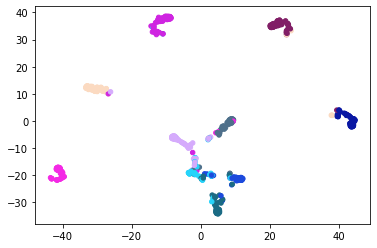

In [13]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data                             #
#############################################################################
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [14]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]


#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
from utils.classifiers.softmax import softmax
input_x = model.layers[0].feedforward(X)
input_x = model.layers[1].feedforward(input_x)
out = softmax(input_x)
Y = tsne(out, low_dim=2, perplexity=50.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.3496448621461064
The 100 th loop cost: 7.106444006247752, computation time: 2.3259572982788086
The 200 th loop cost: 0.1384843943406676, computation time: 4.493960618972778
The 300 th loop cost: 0.12336262221627098, computation time: 6.654957294464111
The 400 th loop cost: 0.11889269751856013, computation time: 8.90795612335205
The 500 th loop cost: 0.11719422152132947, computation time: 11.070958852767944
The 600 th loop cost: 0.11625273163095846, computation time: 13.22398567199707
The 700 th loop cost: 0.11557788349535493, computation time: 15.333985567092896
The 800 th loop cost: 0.11501440787840995, computation time: 17.53895926475525
The 900 th loop cost: 0.1144897768564553, computation time: 19.663957118988037
The 1000 th loop cost: 0.11397918706631578, computation time: 21.761958122253418
it takes 81.87928414344788 seconds


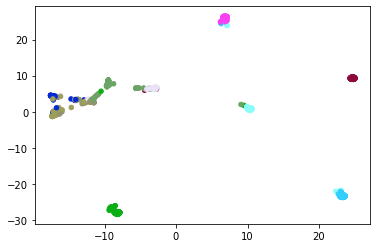

In [15]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################